In [1]:
%matplotlib inline

import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt
from biothings_client import get_client

from data_tools import obo_processing as ot
from data_tools.df_processing import expand_col_on_char, expand_split_col, expand_df_on_col, \
                                     combine_group_cols_on_char
from data_tools import graphs as gt
from data_tools.files import  load_api_results

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_dir = Path('../2_pipeline/00_download_data/out/').resolve()
prev_nw = Path('../2_pipeline/05a_GO_Annotations/out/').resolve()

this_file = '05b_Other_Ontologies'
out_dir = Path('../2_pipeline/').joinpath(this_file).joinpath('out').resolve()

In [3]:
if not out_dir.exists():
    out_dir.mkdir(parents=True)

### Previous taxa used... Will only be mapping to these taxa

In [4]:
nodes = pd.read_csv(prev_nw.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(prev_nw.joinpath('edges.csv'), dtype=str)

In [5]:
combo = gt.combine_nodes_and_edges(nodes, edges)

In [6]:
inf_taxa = combo.query('start_label == "Taxon" and end_label == "Disease" and type == "causes"')['start_id'].unique()
len(inf_taxa)

12227

In [7]:
pd.Series(inf_taxa).apply(lambda s: s.split(':')[0]).value_counts()

NCBITaxon    12176
WD              51
dtype: int64

We won't have info on taxa with WikiData IDs...  so remove.

In [8]:
inf_taxa = [t for t in inf_taxa if t.startswith('NCBITaxon:')]

## Make a map from parent to child Taxa... that are already in the NW

Some Ontologies only map to general taxa.  We've already done a decent job of filtering of Species level taxa in earlier WikiData queries, so for now map these general taxa down to those levels.

this takes several minutes so save and reload on future Runs...

In [9]:
tax_file = out_dir.joinpath('infectious_taxa_lineage_map.pkl')

if tax_file.exists():
    inf_tax_map = pickle.load(tax_file.open(mode='rb'))
else:
    # Get a parent to child map (all childeren-of-children) for all Taxa 
    tax_edges = ot.get_ontology_edges(data_dir.joinpath('ncbitaxon.obo'))
    tax_child_map = ot.get_children_map(tax_edges)

    # Set operations are fast
    inf_taxa = set(inf_taxa)

    # Only keep the ones that map to our infectious taxa
    inf_tax_map = {k: v.intersection(inf_taxa) for k, v in tax_child_map.items()}
    inf_tax_map = {k: v for k, v in inf_tax_map.items() if v}
    
    # Save for future runs
    pickle.dump(inf_tax_map, tax_file.open(mode='wb'))
    
len(inf_tax_map)

4249

# Load the ontologies to be examined

In [10]:
pr_edges = ot.get_ontology_edges(data_dir.joinpath('pr.obo'))
cl_edges = ot.get_ontology_edges(data_dir.joinpath('cl.obo'))
chebi_edges = ot.get_ontology_edges(data_dir.joinpath('chebi.obo'))
ub_edges = ot.get_ontology_edges(data_dir.joinpath('ext.obo'))
hp_edges = ot.get_ontology_edges(data_dir.joinpath('hpo.obo'))

In [11]:
go_json = json.load(open(data_dir.joinpath('go-plus.json'), 'r'))

In [12]:
go_nodes, go_edges = ot.parse_json_graph(go_json['graphs'][0])

In [13]:
# Add source info now...
pr_edges['source'] = 'Protein Ontology'
cl_edges['source'] = 'Cell Ontology'
chebi_edges['source'] = 'ChEBI'
ub_edges['source'] = 'UBERON'
hp_edges['source'] = 'Human Phenotype Ontology'
go_edges['source'] = 'Gene Ontology'

In [14]:
# Add dsrc_type info now...
pr_edges['dsrc_type'] = 'curated'
cl_edges['dsrc_type'] = 'curated'
chebi_edges['dsrc_type'] = 'curated'
ub_edges['dsrc_type'] = 'curated'
hp_edges['dsrc_type'] = 'curated'
go_edges['dsrc_type'] = 'curated'

In [15]:
# Add license info now...
pr_edges['license'] = 'CC-BY 4.0'
cl_edges['license'] = 'CC-BY 4.0'
chebi_edges['license'] = 'CC-BY 4.0'
ub_edges['license'] = 'CC-BY 4.0'
hp_edges['license'] = 'custom cite no-derivatives'
go_edges['license'] = 'CC-BY 4.0'

### Look at inter-ontology edges to see how things are connected

In [16]:
all_onto_edges = pd.concat([pr_edges, cl_edges, chebi_edges, ub_edges, hp_edges, go_edges], 
                           ignore_index=True, sort=False)

all_onto_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),is_a,SO:0001217,protein_coding_gene,Araport,SO,Protein Ontology,curated,CC-BY 4.0
1,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),only_in_taxon,NCBITaxon:3702,Arabidopsis thaliana,Araport,NCBITaxon,Protein Ontology,curated,CC-BY 4.0


In [17]:
examined_ontos = ['CHEBI', 'CL', 'PR', 'UBERON', 'HPO', 'GO', 'NCBITaxon']
q_res = all_onto_edges.query('src_src != tgt_src and src_src in @examined_ontos and tgt_src in @examined_ontos')
m_edges = []
for row in q_res.itertuples():
    m_edges.append((row.src_src, row.tgt_src))
pair_counts = pd.Series(m_edges).value_counts()
pair_counts

(PR, NCBITaxon)        176965
(GO, CHEBI)              5881
(CL, UBERON)             1604
(UBERON, NCBITaxon)      1438
(GO, UBERON)             1308
(CL, PR)                 1225
(PR, GO)                 1167
(GO, CL)                 1063
(CL, GO)                  899
(UBERON, GO)              669
(GO, NCBITaxon)           622
(UBERON, CL)              572
(GO, PR)                  362
(PR, CHEBI)               351
(UBERON, CHEBI)            57
(UBERON, PR)               19
(CHEBI, PR)                 5
(CL, CHEBI)                 2
dtype: int64

In [18]:
pairs = pair_counts.index.tolist()
frac = 0.03
min_counts = 100

for pair in pairs:
    # Only look at pariings with a significant number of edges
    if pair_counts[pair] < min_counts:
        continue
    
    # Print the top relationship types that link two concept types
    print('\n{} ---> {}\n'.format(*pair))
    rels = q_res.query('src_src == {!r} and tgt_src == {!r}'.format(*pair))['rel_type']
    counts = rels.value_counts()
    print(counts[counts > len(rels)*frac])
    print('\n\n'+'-'*40)    


PR ---> NCBITaxon

only_in_taxon    176965
Name: rel_type, dtype: int64


----------------------------------------

GO ---> CHEBI

has_primary_input_or_output                1277
has_primary_output                         1163
has_primary_input                           994
has_input                                   957
transports_or_maintains_localization_of     954
imports                                     178
Name: rel_type, dtype: int64


----------------------------------------

CL ---> UBERON

part_of    1555
Name: rel_type, dtype: int64


----------------------------------------

UBERON ---> NCBITaxon

only_in_taxon        1018
present_in_taxon      348
dubious_for_taxon      61
Name: rel_type, dtype: int64


----------------------------------------

GO ---> UBERON

results_in_development_of      587
results_in_morphogenesis_of    340
results_in_formation_of        174
occurs_in                       70
results_in_maturation_of        53
Name: rel_type, dtype: int64


------

## Choosing edge types to process

`is_a` relationships, or those with very low counts are not super interesting
Based on this analysis, we will keep the following cross-ontology references...

- CL to PR
- ######PR to GO#### Only seems to be output_of  GO:0016485 (protein processing)... or is_a  GO:0032991 (complex)... we will skip
- CL to UBERON
- CL to GO 
- UBERON to GO
- UBERON to CL
- GO to CHEBI
- GO to UBERON
- GO to CL
- GO to NCBITaxon

## PR processing

PR is structured interestingly in that there are protein classes (identifiers that begein with PR:000xxxxxxx) and proteins (which have PR:{Uniprot ID}). Ournetwork already has classes of proteins from interpro... However, most cross ontologies link to these class nodes.  Class nodes tcan then be madded to uniprot nodes, so we can get direct mappings from other ontologies (like CL) to Uniprot by using these.

PR also has proteins from many different species.  We are primarly interested in either human proteins, or proteins of infectious diseeases, so we will filter out taxa that do not fit into those categories.

In [19]:
pr_nodes = ot.get_ontology_nodes(data_dir.joinpath('pr.obo'))
print(len(pr_nodes))
pr_nodes.head(2)

316242


,id,name,def,alt_id,xref,replaced_by,is_obsolete,id_src
0,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),"""A protein coding gene NAC001 in Arabidopsis t...",NaN,NaN,NaN,False,Araport
1,Araport:AT1G01030,NGA3 (Arabidopsis thaliana),"""A protein coding gene NGA3 in Arabidopsis tha...",NaN,NaN,NaN,False,Araport


In [20]:
pr_nodes['id_src'].unique()

array(['Araport', 'BFO', 'CGNC', 'CHEBI', 'EcoGene', 'Ensembl',
       'EnsemblBacteria', 'FlyBase', 'GO', 'HGNC', 'MGI', 'MOD',
       'NCBIGene', 'NCBITaxon', 'OBI', 'PR', 'PomBase', 'RGD', 'SGD',
       'SO', 'WormBase', 'ZFIN', 'dictyBase'], dtype=object)

Most use the standard prefix, but up until this point we've ben using ENSG as the curi for ensembl, so lets change that before going further

In [21]:
pr_nodes['id'] = pr_nodes['id'].str.replace('Ensembl:', 'ENSG:')

pr_edges['src_id'] = pr_edges['src_id'].str.replace('Ensembl:', 'ENSG:')
pr_edges['tgt_id'] = pr_edges['tgt_id'].str.replace('Ensembl:', 'ENSG:')

In [22]:
pr_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),is_a,SO:0001217,protein_coding_gene,Araport,SO,Protein Ontology,curated,CC-BY 4.0
1,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),only_in_taxon,NCBITaxon:3702,Arabidopsis thaliana,Araport,NCBITaxon,Protein Ontology,curated,CC-BY 4.0


In [23]:
idx = pr_edges.query('rel_type == "only_in_taxon"').index
pr_edges.loc[idx, 'tax_id'] = pr_edges.loc[idx, 'tgt_id']

In [24]:
ok_taxa = [k for k in inf_tax_map.keys()] + list(inf_taxa) + ['NCBITaxon:9606']

In [25]:
other_proteins = pr_edges.query('rel_type == "only_in_taxon" and tax_id not in @ok_taxa')['src_id'].unique()
len(other_proteins)

183562

In [26]:
# Prefixes on human proteins
ok_prefix = pr_edges.query('rel_type == "only_in_taxon" and tax_id in @ok_taxa')['src_src'].unique()
ok_prefix

array(['Ensembl', 'HGNC', 'NCBIGene', 'PR', 'WormBase'], dtype=object)

In [27]:
print(len(pr_nodes))
ok_pr_nodes = pr_nodes.query('id not in @other_proteins').copy()
print(len(ok_pr_nodes))

316242
132680


In [28]:
ok_pr_nodes['id_src'].unique()

array(['BFO', 'CHEBI', 'Ensembl', 'GO', 'HGNC', 'MOD', 'NCBIGene',
       'NCBITaxon', 'OBI', 'PR', 'SO', 'WormBase'], dtype=object)

In [29]:
ok_pr_nodes = ok_pr_nodes.query('id_src in @ok_prefix').copy()
ok_pr_nodes.head(2)

,id,name,def,alt_id,xref,replaced_by,is_obsolete,id_src
20636,ENSG:WBGene00016208,C29E4.11 (worm),"""A protein coding gene C29E4.11 in worm."" [PRO...",NaN,NaN,NaN,False,Ensembl
20637,ENSG:WBGene00022423,nhr-41 (worm),"""A protein coding gene nhr-41 in worm."" [PRO:DNx]",NaN,NaN,NaN,False,Ensembl


In [30]:
ok_pr_nodes.query('id_src == "NCBIGene"').sample(5)

,id,name,def,alt_id,xref,replaced_by,is_obsolete,id_src
63210,NCBIGene:1199124,rpmJ (Enterococcus faecalis V583),"""A protein coding gene rpmJ in Enterococcus fa...",NaN,NaN,NaN,False,NCBIGene
63541,NCBIGene:13917115,ospG (Shigella flexneri),"""A protein coding gene ospG in Shigella flexne...",NaN,NaN,NaN,False,NCBIGene
63540,NCBIGene:13917100,lpxM2 (Shigella flexneri),"""A protein coding gene lpxM2 in Shigella flexn...",NaN,NaN,NaN,False,NCBIGene
63518,NCBIGene:13875430,plasmid SAP064A blaZ (Staphylococcus aureus),"""A protein coding gene plasmid SAP064A blaZ in...",NaN,NaN,NaN,False,NCBIGene
63524,NCBIGene:13905363,plasmid pNDM-HK blaTEM-1 (Escherichia coli),"""A protein coding gene plasmid pNDM-HK blaTEM-...",NaN,NaN,NaN,False,NCBIGene


In [31]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "NCBIGene"')['id'].values.tolist())).head(6)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tax_id
125235,NCBIGene:100129307,LOC100129307 (human),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,Protein Ontology,curated,CC-BY 4.0,NaN
125236,NCBIGene:100129307,LOC100129307 (human),only_in_taxon,NCBITaxon:9606,Homo sapiens,NCBIGene,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:9606
125237,NCBIGene:100131107,LOC100131107 (human),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,Protein Ontology,curated,CC-BY 4.0,NaN
125238,NCBIGene:100131107,LOC100131107 (human),only_in_taxon,NCBITaxon:9606,Homo sapiens,NCBIGene,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:9606
125273,NCBIGene:100137021,trp-i (Salmo salar),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,Protein Ontology,curated,CC-BY 4.0,NaN
125274,NCBIGene:100137021,trp-i (Salmo salar),only_in_taxon,NCBITaxon:8030,Salmo salar,NCBIGene,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:8030


In [32]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "NCBIGene"')['id'].values.tolist()))['tgt_name'].value_counts()

protein_coding_gene                              238
Escherichia coli                                  48
Leptospira interrogans serovar Lai str. 56601     39
Klebsiella pneumoniae                             33
Staphylococcus aureus                             26
Homo sapiens                                      20
Enterococcus faecalis V583                        11
Chlamydia trachomatis D/UW-3/CX                   10
Caenorhabditis elegans                             8
Chlamydia trachomatis 434/Bu                       7
Yersinia pestis                                    7
Shigella flexneri                                  6
Bacillus anthracis                                 4
Streptococcus mutans UA159                         4
Salmo salar                                        2
Pseudomonas aeruginosa                             2
Yersinia enterocolitica                            2
Serratia marcescens                                1
Lactobacillus fermentum                       

Unneded edges

In [33]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "HGNC"')['id'].values.tolist()))['tgt_name'].value_counts()

protein_coding_gene    19793
Homo sapiens           19793
Name: tgt_name, dtype: int64

More Unneded-edges... We know Human genes are in Homo Sapiens, and we know they code proteins...

Looks like only the `PR` nodes are useful to us

In [34]:
ok_pr_nodes = ok_pr_nodes.query('id_src == "PR"').copy()
ok_pr_nodes.sample(5)

,id,name,def,alt_id,xref,replaced_by,is_obsolete,id_src
109069,PR:000043199,caseinolytic peptidase B protein isoform 2,"""A caseinolytic peptidase B protein that is a ...",NaN,NaN,NaN,False,PR
107859,PR:000041989,phosphatidylcholine:ceramide cholinephosphotra...,"""A phosphatidylcholine:ceramide cholinephospho...",NaN,NaN,NaN,False,PR
208261,PR:Q68CJ9-2,cyclic AMP-responsive element-binding protein ...,"""A cyclic AMP-responsive element-binding prote...",NaN,UniProtKB:Q68CJ9-2,NaN,False,PR
276602,PR:Q9UN36-2,protein NDRG2 isoform 2 (human),"""A protein NDRG2 isoform 2 that is encoded in ...",NaN,UniProtKB:Q9UN36-2,NaN,False,PR
130947,PR:O43561,linker for activation of T-cells family member...,"""A linker for activation of T-cells family mem...",NaN,"Reactome:R-HSA-202322 ""PR:O43561 located_in GO...",NaN,False,PR


In [35]:
ok_pr_ids = ok_pr_nodes['id'].unique()
ok_pr_edges = pr_edges.query('src_id in @ok_pr_ids').copy()
len(ok_pr_edges)

242338

In [36]:
ok_pr_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tax_id
135970,PR:000000001,protein,is_a,PR:000018263,amino acid chain,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
135971,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,is_a,PR:000000001,protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN


### Get some protein to taxa links for our infectious diseases

In [37]:
inf_proteins = ok_pr_edges.query('tax_id != "NCBITaxon:9606"').dropna(subset=['tax_id']).copy()

In [38]:
inf_proteins['tax_id'] = inf_proteins['tax_id'].map(inf_tax_map).fillna(inf_proteins['tgt_id'])
inf_proteins['tax_id'] = inf_proteins['tax_id'].apply(lambda t: '|'.join(list(t)) if type(t) == set else t)

In [39]:
inf_proteins = expand_col_on_char(inf_proteins, 'tax_id', '|')

In [40]:
inf_proteins.sample(5)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tax_id
61648,PR:000036194,eukaryotic protein,only_in_taxon,NCBITaxon:2759,Eukaryota,PR,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:1172388
77144,PR:Q6BER5-6,nucleosome-remodeling factor subunit NURF301-l...,only_in_taxon,NCBITaxon:6239,Caenorhabditis elegans,PR,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:6239
26316,PR:000008016,eukaryotic-type beta-galactosidase,only_in_taxon,NCBITaxon:2759,Eukaryota,PR,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:681701
40023,PR:000027575,"fungal histone H3.1/H3.2, initiator methionine...",only_in_taxon,NCBITaxon:4751,Fungi,PR,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:1196546
12714,PR:000000427,fungal/metazoan cullin-1 isoform 1 neddylated ...,only_in_taxon,NCBITaxon:33154,Opisthokonta,PR,NCBITaxon,Protein Ontology,curated,CC-BY 4.0,NCBITaxon:1531934


In [41]:
inf_pr_nodes = (inf_proteins[['src_id', 'src_name']]
                .rename(columns={'src_id': 'id', 'src_name': 'name'})
                .drop_duplicates()
                .reset_index(drop=True))
inf_pr_nodes['label'] = 'Gene'
inf_pr_nodes.head()

,id,name,label
0,PR:000000092,fungal/metazoan cullin-1,Gene
1,PR:000000267,fungal/metazoan cullin-1 isoform 1,Gene
2,PR:000000427,fungal/metazoan cullin-1 isoform 1 neddylated ...,Gene
3,PR:000000542,fungal/metazoan cullin-1 isoform 1 neddylated 1,Gene
4,PR:000001119,animal opsin,Gene


In [42]:
pr_to_tax_edges = inf_proteins.rename(columns={'src_id': 'start_id', 'tax_id': 'end_id', 'rel_type': 'type'})

pr_to_tax_edges = gt.order_cols(pr_to_tax_edges.drop(['src_name', 'tgt_id', 'tgt_name', 'src_src', 'tgt_src'], axis=1))
pr_to_tax_edges.head(2)

,start_id,end_id,type,source,dsrc_type,license
0,PR:000000092,NCBITaxon:1235003,only_in_taxon,Protein Ontology,curated,CC-BY 4.0
1,PR:000000092,NCBITaxon:344394,only_in_taxon,Protein Ontology,curated,CC-BY 4.0


#### Separate the Protein Classes from the actual proteins with uniprot ids

In [43]:
ok_pr_nodes['id_part'] = ok_pr_nodes['id'].str.split(':', expand=True)[1]

In [44]:
pr_ids = ok_pr_nodes['id_part'].str.startswith('000')
ok_pr_nodes[pr_ids].sample(5)

,id,name,def,alt_id,xref,replaced_by,is_obsolete,id_src,id_part
72775,PR:000004384,tether containing UBX domain for GLUT4,"""A protein that is a translation product of th...",NaN,NaN,NaN,False,PR,000004384
114610,PR:000048756,"phosphoglycerate kinase 1, initiator methionin...","""A phosphoglycerate kinase 1 (human) that has ...",NaN,"Reactome:R-HSA-70483 ""PR:000048756 located_in ...",NaN,False,PR,000048756
106552,PR:000040682,upstream stimulatory factor 2 isoform 1,"""An upstream stimulatory factor 2 that is a tr...",NaN,NaN,NaN,False,PR,000040682
84891,PR:000016616,trafficking protein particle complex subunit 5,"""A protein that is a translation product of th...",NaN,NaN,NaN,False,PR,000016616
89013,PR:000020752,"NLR family member X1, transit peptide removed ...","""An NLR family member X1 that has had the tran...",NaN,NaN,NaN,False,PR,000020752


In [45]:
other_ids = ok_pr_nodes[~pr_ids]['id'].unique()
pr_ids = ok_pr_nodes[pr_ids]['id'].unique()

Our network already has most of the IDs in Entrezgene space... so we need to map from uniprot to entrez

In [46]:
# These are the ids that we're going to need to map to entrezgene
ok_pr_edges.query('src_id in @other_ids and rel_type == "is_a"').sample(10)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tax_id
373645,PR:P58397,a disintegrin and metalloproteinase with throm...,is_a,PR:000029067,Homo sapiens protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
368533,PR:P54098,DNA polymerase subunit gamma-1 (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
727016,PR:W5XKT8-1,sperm acrosome membrane-associated protein 6 i...,is_a,PR:W5XKT8,sperm acrosome membrane-associated protein 6 (...,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
518396,PR:Q6W5P4-5,neuropeptide S receptor isoform h5 (human),is_a,PR:Q6W5P4,neuropeptide S receptor (human),PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
585175,PR:Q8TDQ1,CMRF35-like molecule 1 (human),is_a,PR:000005168,CMRF35-like molecule 1,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
232484,PR:E9PB15-1,protein PTGES3L isoform h1 (human),is_a,PR:E9PB15,protein PTGES3L (human),PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
250246,PR:O17388,F08F1.7 (worm),is_a,PR:000016390,transmembrane 9 superfamily member 2,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
420561,PR:Q14188-2,transcription factor Dp-2 isoform Beta (human),is_a,PR:Q14188,transcription factor Dp-2 (human),PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
517485,PR:Q6UX40-2,transmembrane protein 107 isoform h2 (human),is_a,PR:Q6UX40,transmembrane protein 107 (human),PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
353794,PR:P43686-1,26S proteasome regulatory subunit 6B isoform 1...,is_a,PR:P43686,26S proteasome regulatory subunit 6B (human),PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN


In [47]:
to_query = [p.split(':')[1] for p in other_ids]
len(to_query)

61443

In [48]:
to_query = set([q.split('-')[0] for q in to_query])
len(to_query)

24534

In [49]:
mg = get_client('gene')
qres = load_api_results(out_dir.joinpath('mg_pr_query_res_{}.pkl'), re_scrape=False, scrape_function=mg.querymany, qterms=to_query, 
                        scopes='uniprot,accession.protein', fields='entrezgene,name,taxid,symbol,uniprot',
                        size=10)
len(qres)

25490

In [50]:
import collections
import six


def iterable(arg):
    return isinstance(arg, collections.Iterable) and not isinstance(arg, six.string_types)


def process_inner(res, key, base_key):
    new_key = base_key+'.'+key
    new_key = new_key.lower().replace(' ', '_').replace('-', '_')

    out = res.get(base_key, dict()).get(key)
    if iterable(out):
        out = '|'.join(out)
    return new_key, out
        


for res in qres:
    k, v = process_inner(res, 'Swiss-Prot', 'uniprot')
    res[k] = v
    k, v = process_inner(res, 'TrEMBL', 'uniprot')
    res[k] = v

df = pd.DataFrame(qres)
df = df.drop('uniprot', axis=1)
len(df)

25490

In [51]:
df.head(2)

,query,_id,_score,entrezgene,name,symbol,taxid,uniprot.swiss_prot,uniprot.trembl,notfound
0,P34675,176108,12.694130,176108,Ubiquitin-like domain-containing protein,ZK688.5,6239.0,P34675,L8EC34|L8E805,NaN
1,Q4KMP7,26000,15.069444,26000,TBC1 domain family member 10B,TBC1D10B,9606.0,Q4KMP7,H3BSE1,NaN


In [52]:
df.count()

query                 25490
_id                   25065
_score                25065
entrezgene            24689
name                  25065
symbol                25065
taxid                 25065
uniprot.swiss_prot    23884
uniprot.trembl        16160
notfound                425
dtype: int64

In [53]:
df.nunique()

query                 24534
_id                   24827
_score                 5743
entrezgene            24451
name                  23756
symbol                24389
taxid                    60
uniprot.swiss_prot    23195
uniprot.trembl        15870
notfound                  1
dtype: int64

In [54]:
coverage = df.drop_duplicates(subset=['query'])['entrezgene'].nunique() / df['query'].nunique()
"Uniprot to entrez mapping success: {:3.2%}".format(coverage)

'Uniprot to entrez mapping success: 97.90%'

In [55]:
df['taxid'] = ('NCBITaxon:'+df['taxid'].fillna(0).astype(int).astype(str)).replace('NCBITaxon:0', float('nan'))

In [56]:
# Git rid of failed Queries
uni_to_entrez = df.dropna(subset=['entrezgene']).reset_index(drop=True)
# Combine the uniprot id and symbol as a xref
uni_to_entrez['xrefs'] = 'SYM:' + uni_to_entrez['symbol'] + '|' + 'UniProt:' + uni_to_entrez['query']
# Keep the columns we care about
uni_to_entrez = uni_to_entrez[['query', 'entrezgene', 'name', 'xrefs', 'taxid']].reset_index(drop=True)

# Add back CURIs for integration
uni_to_entrez['entrezgene'] = 'NCBIGene:' + uni_to_entrez['entrezgene']
uni_to_entrez['pr_id'] = 'PR:' + uni_to_entrez['query']

uni_to_entrez.sample(10)

,query,entrezgene,name,xrefs,taxid,pr_id
14036,Q8NEM2,NCBIGene:79801,SHC binding and spindle associated 1,SYM:SHCBP1|UniProt:Q8NEM2,NCBITaxon:9606,PR:Q8NEM2
23193,Q9UBE0,NCBIGene:10055,SUMO1 activating enzyme subunit 1,SYM:SAE1|UniProt:Q9UBE0,NCBITaxon:9606,PR:Q9UBE0
5940,P47736,NCBIGene:5909,RAP1 GTPase activating protein,SYM:RAP1GAP|UniProt:P47736,NCBITaxon:9606,PR:P47736
17768,P25713,NCBIGene:4504,metallothionein 3,SYM:MT3|UniProt:P25713,NCBITaxon:9606,PR:P25713
4463,P08294,NCBIGene:6649,superoxide dismutase 3,SYM:SOD3|UniProt:P08294,NCBITaxon:9606,PR:P08294
22387,Q8N339,NCBIGene:4499,metallothionein 1M,SYM:MT1M|UniProt:Q8N339,NCBITaxon:9606,PR:Q8N339
968,Q86VH2,NCBIGene:55582,kinesin family member 27,SYM:KIF27|UniProt:Q86VH2,NCBITaxon:9606,PR:Q86VH2
6341,Q9NXJ0,NCBIGene:54860,membrane spanning 4-domains A12,SYM:MS4A12|UniProt:Q9NXJ0,NCBITaxon:9606,PR:Q9NXJ0
24304,Q18616,NCBIGene:183453,Structural maintenance of chromosomes-like pro...,SYM:smcl-1|UniProt:Q18616,NCBITaxon:6239,PR:Q18616
20189,O00141,NCBIGene:6446,serum/glucocorticoid regulated kinase 1,SYM:SGK1|UniProt:O00141,NCBITaxon:9606,PR:O00141


Some of these may already exist in our network as UniProt IDs.  Lets make sure and if they do, convert them to EntrezGene for a more consistent identifer source

In [57]:
uni_to_entrez['uni_id'] = 'UniProt:'+uni_to_entrez['query']
uni_to_entrez['label'] = 'Gene'

In [58]:
nodes = gt.re_id_nodes(nodes, uni_to_entrez, 'uni_id', 'entrezgene')
edges = gt.re_id_edges(edges, uni_to_entrez[['uni_id', 'entrezgene']])

In [59]:
nodes = combine_group_cols_on_char(nodes, ['id'], ['xrefs'], sort=True, prog=False)

In [60]:
node_ids = nodes['id'].unique()

In [61]:
nodes['id'].isnull().sum()

0

## is_a from PR to entrez

In [62]:
ok_pr_edges.query('rel_type == "is_a" and src_id in @other_ids and tgt_id in @pr_ids')['tgt_name'].nunique()

24647

In [63]:
uniprot_to_pr = ok_pr_edges.query('rel_type == "is_a" and src_id in @other_ids and tgt_id in @pr_ids').copy()
uniprot_to_pr.sample(10)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tax_id
576881,PR:Q8NGH7,olfactory receptor 52L1 (human),is_a,PR:000011896,olfactory receptor 52L1,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
613339,PR:Q96L46,calpain small subunit 2 (human),is_a,PR:000005023,calpain small subunit 2,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
257525,PR:O43790,"keratin, type II cuticular Hb6 (human)",is_a,PR:000029067,Homo sapiens protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
358269,PR:P48509,CD151 antigen (human),is_a,PR:000005158,CD151 molecule,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
357116,PR:P47884,olfactory receptor 1D4 (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
351529,PR:P42357-1,histidine ammonia-lyase isoform 1 (human),is_a,PR:000039439,histidine ammonia-lyase isoform 1,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
257629,PR:O43825,"beta-1,3-galactosyltransferase 2 (human)",is_a,PR:000004584,"beta-1,3-galactosyltransferase 2",PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
521024,PR:Q6ZUI0,tumor protein p63-regulated gene 1 protein (hu...,is_a,PR:000016589,tumor protein p63-regulated gene 1 protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
250177,PR:O17087,poly(A) RNA polymerase gld-2 (worm),is_a,PR:000012263,poly(A) RNA polymerase GLD2,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN
601438,PR:Q92626,peroxidasin homolog (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,Protein Ontology,curated,CC-BY 4.0,NaN


# CL to PR

Now that we have a map from upper PR terms to actual entrez ids, time to map some of these intertology edges, starting with CL

In [64]:
def combine_two_onto_edges(onto1, onto2, src_src, tgt_src, common_cols=True):
    
    # Query for the source an target, concatenate, drop the duplicates.
    out = pd.concat([onto1.query('src_src == @src_src and tgt_src == @tgt_src'),
                      onto2.query('src_src == @src_src and tgt_src == @tgt_src')],
                      ignore_index=True, sort=False).drop_duplicates(subset=['src_id', 'tgt_id', 'rel_type'])
    
    if common_cols:
        cols = min([onto1.columns, onto2.columns], key=len)
        out = out[cols]
    
    return out

def edge_rename(edges, **kwargs):
    # Standard rename from ontology edges to hetnet edges
    rename_map = {'src_id': 'start_id', 'tgt_id': 'end_id', 'rel_type': 'type'}
    # Update with userdefined inputs
    rename_map.update(kwargs)
    return gt.order_cols(edges.rename(columns=rename_map))


In [65]:
cl_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,BFO:0000002,continuant,part_of,BFO:0000002,continuant,BFO,BFO,Cell Ontology,curated,CC-BY 4.0
1,BFO:0000003,occurrent,part_of,BFO:0000003,occurrent,BFO,BFO,Cell Ontology,curated,CC-BY 4.0


In [66]:
# Get a map from a given cl node to all its children
cl_map = ot.get_children_map(cl_edges)

In [67]:
# Some PR relationships are in cl...
cl_map['PR:000001897']

{'PR:000002023', 'PR:P26715'}

In [68]:
pr_map = ot.get_children_map(ok_pr_edges)

In [69]:
cl_to_pr = combine_two_onto_edges(cl_edges, ok_pr_edges, 'CL', 'PR')
print(len(cl_to_pr))
cl_to_pr['tgt_child'] = cl_to_pr['tgt_id'].map(pr_map).apply(list)
cl_to_pr = expand_df_on_col(cl_to_pr, 'tgt_child').dropna(subset=['tgt_child'])

1142


In [70]:
pr_in_cl = cl_to_pr['tgt_id'].unique()
len(pr_in_cl)

166

In [71]:
len([p for p in pr_in_cl if p.startswith('PR:000')])

166

Small number of unique protiens... however these represent classes... Need to map to the Uniprot IDS (which we now have mapped to entrez)

In [72]:
cur_pr_ids = []
cur_uniprot_ids = []

for pr_id in pr_in_cl:
    childs = pr_map[pr_id]
    for uni_id in childs & set(other_ids):
        cur_pr_ids.append(pr_id)
        cur_uniprot_ids.append(uni_id)
p2u_for_cl = pd.DataFrame({'pr': cur_pr_ids, 'uniprot': cur_uniprot_ids})
p2u_for_cl.sample(5)

,pr,uniprot
404,PR:000001300,PR:Q9NNX6-3
277,PR:000001381,PR:P14784
320,PR:000001806,PR:Q6EIG7-2
122,PR:000010543,PR:P05164-3
53,PR:000010799,PR:P10242-4


In [73]:
cl_to_pr = cl_to_pr.merge(p2u_for_cl, how='inner', left_on='tgt_id', right_on='pr')
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tgt_child,pr,uniprot
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,PR:000046612,PR:000001002,PR:P15391-2
1,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,PR:000046612,PR:000001002,PR:P15391


Those dashes after a uniqrot id represent isoforms.. however those are not represented in entrez, so we will remove them

In [74]:
cl_to_pr['uniprot_processed'] = cl_to_pr['uniprot'].apply(lambda u: u.split(':')[1].split('-')[0])
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tgt_child,pr,uniprot,uniprot_processed
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,PR:000046612,PR:000001002,PR:P15391-2,P15391
1,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,PR:000046612,PR:000001002,PR:P15391,P15391


In [75]:
cl_to_pr = cl_to_pr.merge(uni_to_entrez, left_on='uniprot_processed', right_on='query').drop_duplicates(subset=['entrezgene', 'src_id'])
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,...,uniprot,uniprot_processed,query,entrezgene,name,xrefs,taxid,pr_id,uni_id,label
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,...,PR:P15391-2,P15391,P15391,NCBIGene:930,CD19 molecule,SYM:CD19|UniProt:P15391,NCBITaxon:9606,PR:P15391,UniProt:P15391,Gene
18,CL:0000094,granulocyte,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,...,PR:P15391-2,P15391,P15391,NCBIGene:930,CD19 molecule,SYM:CD19|UniProt:P15391,NCBITaxon:9606,PR:P15391,UniProt:P15391,Gene


In [76]:
cl_to_pr_edges = edge_rename(cl_to_pr.drop(['tgt_child', 'pr', 'uniprot', 'query', 'label', 'uni_id', 'xrefs'], axis=1), 
                             name='uniprot_name', entrezgene='end_id', tgt_id='orig_tgt', 
                             tgt_name='orig_name', uniprot_processed='uniprot_id')
cl_to_pr_edges.head(2)

,start_id,end_id,type,src_name,orig_tgt,orig_name,src_src,tgt_src,source,dsrc_type,license,uniprot_id,uniprot_name,taxid,pr_id
0,CL:0000037,NCBIGene:930,lacks_plasma_membrane_part,hematopoietic stem cell,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,P15391,CD19 molecule,NCBITaxon:9606,PR:P15391
18,CL:0000094,NCBIGene:930,lacks_plasma_membrane_part,granulocyte,PR:000001002,CD19 molecule,CL,PR,Cell Ontology,curated,CC-BY 4.0,P15391,CD19 molecule,NCBITaxon:9606,PR:P15391


In [77]:
# We punned these edges from a PR class target to the actual entrez gene ID
cl_to_pr_edges['dsrc_type'] = 'computed'
cl_to_pr_edges['comp_type'] = 'punned'

In [78]:
len(cl_to_pr_edges)

1013

In [79]:
cl_to_pr_edges['type'].value_counts()

has_plasma_membrane_part           412
lacks_plasma_membrane_part         392
has_part                            77
has_low_plasma_membrane_amount      64
has_high_plasma_membrane_amount     58
lacks_part                          10
Name: type, dtype: int64

# UBERON and CL

In [80]:
ub_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,BFO:0000004,NaN,is_a,BFO:0000002,NaN,BFO,BFO,UBERON,curated,CC-BY 4.0
1,BFO:0000015,NaN,is_a,BFO:0000003,NaN,BFO,BFO,UBERON,curated,CC-BY 4.0


In [81]:
ub_to_cl = combine_two_onto_edges(ub_edges, cl_edges, 'UBERON', 'CL')
len(ub_to_cl)

342

In [82]:
ub_to_cl.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,UBERON:0000006,islet of Langerhans,has_part,CL:0000168,insulin secreting cell,UBERON,CL,UBERON,curated,CC-BY 4.0
1,UBERON:0000006,islet of Langerhans,has_part,CL:0000172,somatostatin secreting cell,UBERON,CL,UBERON,curated,CC-BY 4.0


In [83]:
cl_to_ub = combine_two_onto_edges(ub_edges, cl_edges, 'CL', 'UBERON')
len(cl_to_ub)

924

In [84]:
cl_to_ub.head()

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,CL:0000028,CNS neuron (sensu Nematoda and Protostomia),part_of,UBERON:0001017,central nervous system,CL,UBERON,UBERON,curated,CC-BY 4.0
1,CL:0000047,neuronal stem cell,part_of,UBERON:0001017,central nervous system,CL,UBERON,UBERON,curated,CC-BY 4.0
2,CL:0000059,ameloblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON,UBERON,curated,CC-BY 4.0
3,CL:0000060,odontoblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON,UBERON,curated,CC-BY 4.0
4,CL:0000061,cementoblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON,UBERON,curated,CC-BY 4.0


In [85]:
cl_to_ub_edges = edge_rename(cl_to_ub)
ub_to_cl_edges = edge_rename(ub_to_cl)

# GO integration

In [86]:
go_nodes.head(2)

,type,name,id,id_src,xrefs,deprecated,date,definition,subsets,synonyms,...,IAO:0100001,IAO:0000231,shorthand,consider,hasScope,creator,IAO:0000589,IAO:0000425,is:class:level,is:metadata:tag
0,CLASS,rhamnoside,CHEBI:26547,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CLASS,rhamnosylglucoside,CHEBI:26548,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
go_edges.head(2)

,rel_type,src_id,src_src,src_name,tgt_id,tgt_src,tgt_name,source,dsrc_type,license
0,is_a,CHEBI:77148,CHEBI,ginsenoside Re,GOCHE:35610,GOCHE,substance with antineoplastic agent role,Gene Ontology,curated,CC-BY 4.0
1,capable_of_part_of,UBERON:0000004,UBERON,nose,GO:0007608,GO,sensory perception of smell,Gene Ontology,curated,CC-BY 4.0


### CL to GO

In [88]:
cl_to_go = combine_two_onto_edges(cl_edges, go_edges, 'CL', 'GO')
print(len(cl_to_go))
go_to_cl = combine_two_onto_edges(cl_edges, go_edges, 'GO', 'CL')
print(len(go_to_cl))

486
1063


In [89]:
cl_to_go['rel_type'].value_counts().head(5)

capable_of                    292
has_plasma_membrane_part       42
has_part                       36
lacks_plasma_membrane_part     28
participates_in                18
Name: rel_type, dtype: int64

In [90]:
go_to_cl['rel_type'].value_counts().head(8)

results_in_acquisition_of_features_of    299
occurs_in                                136
results_in_development_of                 99
results_in_movement_of                    86
acts_on_population_of                     83
part_of                                   66
has_input                                 57
results_in_commitment_to                  57
Name: rel_type, dtype: int64

In [91]:
cl_to_go_edges = edge_rename(cl_to_go)
go_to_cl_edges = edge_rename(go_to_cl)

cl_to_go_edges.sample(2)

,start_id,end_id,type,src_name,tgt_name,src_src,tgt_src,source,dsrc_type,license
71,CL:0000167,GO:0030072,capable_of,peptide hormone secreting cell,peptide hormone secretion,CL,GO,Cell Ontology,curated,CC-BY 4.0
428,CL:0002394,GO:0042590,capable_of,CD141-positive myeloid dendritic cell,antigen processing and presentation of exogeno...,CL,GO,Cell Ontology,curated,CC-BY 4.0


# UBERON to GO

In [92]:
ub_to_go = combine_two_onto_edges(ub_edges, go_edges, 'UBERON', 'GO')
print(len(ub_to_go))
go_to_ub = combine_two_onto_edges(ub_edges, go_edges, 'GO', 'UBERON')
print(len(go_to_ub))

417
1308


In [93]:
ub_to_go.sample(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
350,UBERON:0012423,layer of microvilli,composed_primarily_of,GO:0005902,microvillus,UBERON,GO,UBERON,curated,CC-BY 4.0
205,UBERON:0003926,photoreceptor outer segment layer,has_part,GO:0001750,photoreceptor outer segment,UBERON,GO,UBERON,curated,CC-BY 4.0


In [94]:
go_to_ub.sample(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
41,GO:0072170,metanephric tubule development,results_in_development_of,UBERON:0005106,metanephric tubule,GO,UBERON,Gene Ontology,curated,CC-BY 4.0
834,GO:0060463,lung lobe morphogenesis,results_in_morphogenesis_of,UBERON:0000101,lobe of lung,GO,UBERON,Gene Ontology,curated,CC-BY 4.0


In [95]:
ub_to_go['rel_type'].value_counts().head(5)

capable_of               123
capable_of_part_of       121
has_part                  44
contains_process          28
composed_primarily_of     26
Name: rel_type, dtype: int64

In [96]:
go_to_ub['rel_type'].value_counts().head(8)

results_in_development_of                587
results_in_morphogenesis_of              340
results_in_formation_of                  174
occurs_in                                 70
results_in_maturation_of                  53
results_in_structural_organization_of     28
results_in_growth_of                      20
has_input                                  8
Name: rel_type, dtype: int64

In [97]:
ub_to_go_edges = edge_rename(ub_to_go)
go_to_ub_edges = edge_rename(go_to_ub)

## GO to CHEBI

In [98]:
chebi_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
0,CHEBI:23367,molecular entity,is_a,CHEBI:24431,NaN,CHEBI,CHEBI,ChEBI,curated,CC-BY 4.0
1,CHEBI:24870,ion,is_a,CHEBI:23367,NaN,CHEBI,CHEBI,ChEBI,curated,CC-BY 4.0


Chebi edges don't have the proper target name....

Also, similar to PR, we have some chebi nodes with inchikeys representing true compounds, and others wihtout which are more indiciative of a compound class

In [99]:
chebi_nodes = ot.get_ontology_nodes(data_dir.joinpath('chebi.obo'), 
                                    props=['http://purl.obolibrary.org/obo/chebi/inchikey'])
chebi_nodes = chebi_nodes.rename(columns={'http://purl.obolibrary.org/obo/chebi/inchikey': 'ikey'})

In [100]:
cid_to_name = chebi_nodes.set_index('id')['name'].to_dict()
chebi_edges['tgt_name'] = chebi_edges['tgt_id'].map(cid_to_name)

In [101]:
go_to_chebi = combine_two_onto_edges(chebi_edges, go_edges, 'GO', 'CHEBI')
print(len(go_to_chebi))
go_to_chebi.sample(2)

5881


,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license
3019,GO:0033353,S-adenosylmethionine cycle,has_participant,CHEBI:15414,S-adenosyl-L-methionine,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0
2765,GO:0046512,sphingosine biosynthetic process,has_primary_output,CHEBI:16393,sphingosine,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0


In [102]:
cheb_go_targets = go_to_chebi['tgt_id'].unique()
chebi_nodes.query('id in @cheb_go_targets')['ikey'].count()

1197

In [103]:
len(cheb_go_targets)

2072

In [104]:
go_nodes.dropna(subset=['name'])[go_nodes['name'].dropna().str.contains('organic')]

,type,name,id,id_src,xrefs,deprecated,date,definition,subsets,synonyms,...,IAO:0100001,IAO:0000231,shorthand,consider,hasScope,creator,IAO:0000589,IAO:0000425,is:class:level,is:metadata:tag
162,CLASS,inorganic ion import across plasma membrane,GO:0099587,GO,NaN,NaN,NaN,The directed movement of inorganic ions from o...,NaN,inorganic ion import into cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,CLASS,organic divalent group,CHEBI:51446,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,CLASS,organic univalent group,CHEBI:51447,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,CLASS,organic sulfate salt,CHEBI:51337,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2794,CLASS,organic polycyclic compound,CHEBI:51958,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79608,CLASS,mancude organic heterocyclic parent,CHEBI:35571,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79612,CLASS,mancude organic heterobicyclic parent,CHEBI:35570,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79614,CLASS,organic mancude parent,CHEBI:35573,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79676,CLASS,heterocyclic organic fundamental parent,CHEBI:35552,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So about half go directly to a compound with an inchi, and the other half go to some upper ontology term.

### Sensible mapping of compound classes to compounds

We are most interested in leaf nodes, but mapping from upper ontology terms is insane... some like `organic molecular entity` have 1000's of children, so the GO terms `organic cyclic compound metabolic proces` will explode the number of edges, while reducing specificity, adding noise. We need a strategy to map somewhat general CHEBI terms to specific compounds.  However, ontology structure (where a specified distiance from the root or leaves does not a consistent level of specificity)  means that simply starting at the leaf nodes and walking up 1 or 2 levels will result in many of these top-level terms also being selected. 

Here is the ouline for the strategy we will employ to help combat this.

1. Start with the leaf nodes (in CHEBI, we will define these as nodes with an inchi-key cross-reference)
2. Walk up 1 level
3. Determine how many childern each parent now contains at this 1-level subset
4. Determine total number of childern (leaves and intermediary nodes) that this parent has within the full ontology.
5. Take an arbitrary cutoff value for the ratio of these two numbers (Determined in 3 & 4), above which we keep and below which we discard.
6. Potentially we could also add in a minimum number of total children to be considered for removal (those with few total childern in the ontotlogy are most likely not upper level terms.
7. For those terms that pass filtering, map to all child terms at all levels in the ontololgy.

In [105]:
def get_subset_onto_levels(edges, start_nodes, direction, levels=1):

    assert direction.lower() in ['up', 'down']
    assert levels > 0
    
    if direction == 'up':
        query_col = 'src_id'
        gather_col = 'tgt_id'
    elif direction == 'down':
        query_col = 'tgt_id'
        gather_col = 'src_id'
    
    out = edges.query('{} in @start_nodes and rel_type == "is_a"'.format(query_col)).copy()
    found_ids = set(start_nodes)
    
    for i in range(levels-1):
        new_ids = set(out[gather_col]) - found_ids
        found_ids.update(new_ids)
        
        this_level = edges.query('{} in @new_ids and rel_type == "is_a"'.format(query_col)).copy()
        out = pd.concat([out, this_level], ignore_index=True).drop_duplicates()
        
    return out


In [106]:
chebi_map = ot.get_children_map(chebi_edges)

In [107]:
leaf_ids = chebi_nodes.dropna(subset=['ikey'])['id'].values
lvl_1 = get_subset_onto_levels(chebi_edges, leaf_ids, 'up', levels=1)

lv1_map = ot.get_children_map(lvl_1)

In [108]:
# 
map_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in lv1_map.items()])),
              'child': list(chain(*[v for v in lv1_map.values()]))}).groupby('parent').apply(len)

total_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in chebi_map.items()])),
              'child': list(chain(*[v for v in chebi_map.values()]))}).groupby('parent').apply(len)

leaf_maps = (pd.concat([map_vals, total_vals], axis=1, sort=False)
                    .rename(columns={0:'lv1_children', 1:'total_children'})
                    .dropna(subset=['lv1_children']))

leaf_maps = leaf_maps.reset_index().rename(columns={'index': 'id'})
leaf_maps['name'] = leaf_maps['id'].map(chebi_nodes.set_index('id')['name'].to_dict())
leaf_maps.head(2)

,id,lv1_children,total_children,name
0,CHEBI:10036,20.0,22,wax ester
1,CHEBI:102167,2.0,2,"N-\{4-[2-ethyl-1-(1,2,4-triazol-1-yl)butyl]phe..."


In [109]:
saturation = leaf_maps['lv1_children'] / leaf_maps['total_children'] 
leaf_maps['saturation'] = saturation
leaf_maps.sort_values('saturation').head(5)

,id,lv1_children,total_children,name,saturation
3205,CHEBI:33675,1.0,105997,p-block molecular entity,0.000009
3044,CHEBI:33285,2.0,80878,heteroorganic entity,0.000025
1958,CHEBI:24532,1.0,38646,organic heterocyclic compound,0.000026
1999,CHEBI:24651,1.0,16481,hydroxides,0.000061
6198,CHEBI:5686,3.0,38677,heterocyclic compound,0.000078


These all look like upper ontology terms... seems like the strategy is working

In [110]:
# Cutoffs (inclusive)
frac = 0.5
cutoff_total_children = 15

idx = saturation >= frac
idx = idx | (leaf_maps['total_children'] <= cutoff_total_children)

print('{} total items above 1 level above leaf nodes'.format(len(idx)))
print('{} items pass filtering at frac={:.2g} or total_chidren<={}'.format(idx.sum(), frac, cutoff_total_children))

leaf_maps[~idx].sort_values('saturation', ascending=False).head(5)

8829 total items above 1 level above leaf nodes
7877 items pass filtering at frac=0.5 or total_chidren<=15


,id,lv1_children,total_children,name,saturation
6907,CHEBI:63353,248.0,497,disaccharide derivative,0.498994
2440,CHEBI:26407,149.0,300,pyrans,0.496667
1878,CHEBI:24129,299.0,603,furans,0.495854
2861,CHEBI:29256,44.0,89,thiol,0.494382
8007,CHEBI:78206,25.0,51,fatty acid ethyl ester,0.490196


In [111]:
# For some reason, passing bins=20 was producing inconsistent binning 
# between the 2 graphs...
bins=20
s=0
e=1
stp=(e-s)/bins
e += stp  # add extra step: [start, end)

bins = np.arange(s,e,stp)

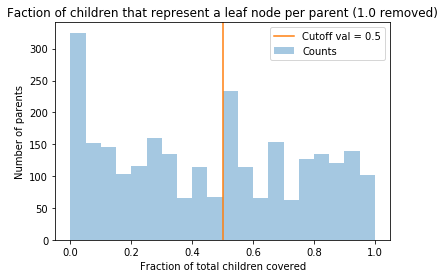

In [112]:
sns.distplot(saturation[saturation != 1], kde=False, bins=bins, label='Counts')
plt.axvline(frac, c=sns.color_palette()[1], label='Cutoff val = {:1.2g}'.format(frac))
plt.legend()
plt.xlabel('Fraction of total children covered')
plt.ylabel('Number of parents')
plt.title('Faction of children that represent a leaf node per parent (1.0 removed)');

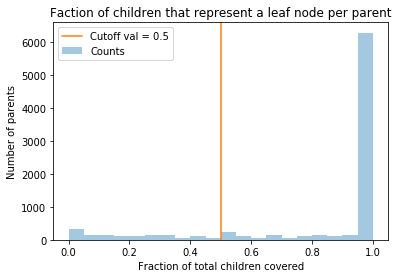

In [113]:
sns.distplot(saturation, kde=False, bins=bins, label='Counts')
plt.axvline(frac, c=sns.color_palette()[1], label='Cutoff val = {:1.2g}'.format(frac))
plt.legend()
plt.xlabel('Fraction of total children covered')
plt.ylabel('Number of parents')
plt.title('Faction of children that represent a leaf node per parent');

In [114]:
keep_for_map = leaf_maps[idx]['id'].tolist()
final_map = {k: list(v) for k, v in chebi_map.items() if k in keep_for_map}

go_to_chebi['tgt_child'] = go_to_chebi['tgt_id'].map(final_map)

go_to_chebi = expand_df_on_col(go_to_chebi, 'tgt_child')
len(go_to_chebi)

48529

In [115]:
go_to_chebi.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tgt_child
0,GO:0035942,dehydroepiandrosterone secretion,transports_or_maintains_localization_of,CHEBI:28689,dehydroepiandrosterone,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN
1,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN


In [116]:
# Some GO are mapped to a compound class, so we want the mappings to the actual compounds
other_edges = go_to_chebi.dropna(subset=['tgt_child']).drop('tgt_id', axis=1).rename(columns={'tgt_child': 'tgt_id'})
other_edges['dsrc_type'] = 'computed'
other_edges['comp_type'] = 'punning'

In [117]:
go_to_cheb_edges = (pd.concat([go_to_chebi, other_edges], sort=False, ignore_index=True)
                        .drop_duplicates(subset=['src_id', 'rel_type', 'tgt_id']))

In [118]:
len(go_to_cheb_edges)

50012

In [119]:
go_to_cheb_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tgt_child,comp_type
0,GO:0035942,dehydroepiandrosterone secretion,transports_or_maintains_localization_of,CHEBI:28689,dehydroepiandrosterone,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN,NaN
1,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN,NaN


In [120]:
go_to_cheb_edges['tgt_id'].nunique()

16364

In [121]:
go_to_chebi['tgt_id'].nunique()

2072

In [122]:
go_to_cheb_edges['rel_type'].value_counts()

has_primary_input_or_output                14526
has_primary_output                         12577
has_primary_input                           8885
transports_or_maintains_localization_of     6712
has_input                                   5242
imports                                     1141
regulates_level_of                           266
exports                                      246
has_output                                   206
has_intermediate                             149
has_participant                               37
has_part                                      13
mediated_by                                   12
Name: rel_type, dtype: int64

In [123]:
go_to_cheb_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,source,dsrc_type,license,tgt_child,comp_type
0,GO:0035942,dehydroepiandrosterone secretion,transports_or_maintains_localization_of,CHEBI:28689,dehydroepiandrosterone,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN,NaN
1,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,Gene Ontology,curated,CC-BY 4.0,NaN,NaN


In [124]:
go_to_cheb_edges = edge_rename(go_to_cheb_edges)

## GO to NCBITaxon

In [125]:
go_to_tax = go_edges.query('src_src == "GO" and tgt_src == "NCBITaxon" and tgt_id in @ok_taxa').copy()
len(go_to_tax)

513

In [126]:
go_to_tax['tax_id'] = go_to_tax['tgt_id'].map(inf_tax_map).fillna(go_to_tax['tgt_id'])
go_to_tax['tax_id'] = go_to_tax['tax_id'].apply(lambda t: '|'.join(list(t)) if type(t) == set else t)

go_to_tax = expand_col_on_char(go_to_tax, 'tax_id', '|')
len(go_to_tax)

1058742

In [127]:
go_to_tax.sample(5)

,rel_type,src_id,src_src,src_name,tgt_id,tgt_src,tgt_name,source,dsrc_type,license,tax_id
554552,only_in_taxon,GO:0005850,GO,eukaryotic translation initiation factor 2 com...,NCBITaxon:2759,NCBITaxon,Eukaryota,Gene Ontology,curated,CC-BY 4.0,NCBITaxon:2133763
347613,only_in_taxon,GO:0071629,GO,cytoplasm protein quality control by the ubiqu...,NCBITaxon:2759,NCBITaxon,Eukaryota,Gene Ontology,curated,CC-BY 4.0,NCBITaxon:1312503
841866,only_in_taxon,GO:1900727,GO,osmoregulated periplasmic glucan biosynthetic ...,NCBITaxon:2,NCBITaxon,Bacteria,Gene Ontology,curated,CC-BY 4.0,NCBITaxon:67274
631270,only_in_taxon,GO:0040007,GO,growth,NCBITaxon:131567,NCBITaxon,cellular organisms,Gene Ontology,curated,CC-BY 4.0,NCBITaxon:130496
806202,only_in_taxon,GO:0071712,GO,ER-associated misfolded protein catabolic process,NCBITaxon:2759,NCBITaxon,Eukaryota,Gene Ontology,curated,CC-BY 4.0,NCBITaxon:1196540


In [128]:
go_to_tax_edges = go_to_tax.rename(columns={'src_id': 'start_id', 'tax_id': 'end_id', 'rel_type': 'type'})

go_to_tax_edges = gt.order_cols(go_to_tax_edges.drop(['src_name', 'tgt_id', 'tgt_name', 'src_src', 'tgt_src'], axis=1))
go_to_tax_edges.head(2)

,start_id,end_id,type,source,dsrc_type,license
0,GO:0048102,NCBITaxon:2018661,only_in_taxon,Gene Ontology,curated,CC-BY 4.0
1,GO:0048102,NCBITaxon:320112,only_in_taxon,Gene Ontology,curated,CC-BY 4.0


# Final edge processing

In [129]:
all_new_edges = [pr_to_tax_edges, cl_to_pr_edges, cl_to_go_edges, cl_to_ub_edges, go_to_cl_edges, 
                 go_to_cheb_edges, go_to_ub_edges, ub_to_cl_edges, ub_to_go_edges, go_to_tax_edges]

In [130]:
all_new_edges = pd.concat(all_new_edges, ignore_index=True, sort=False)
len(all_new_edges)

1192936

In [131]:
all_new_edges.head(2)

,start_id,end_id,type,source,dsrc_type,license,src_name,orig_tgt,orig_name,src_src,tgt_src,uniprot_id,uniprot_name,taxid,pr_id,comp_type,tgt_name,tgt_child
0,PR:000000092,NCBITaxon:1235003,only_in_taxon,Protein Ontology,curated,CC-BY 4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PR:000000092,NCBITaxon:344394,only_in_taxon,Protein Ontology,curated,CC-BY 4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
all_new_edges['type'].value_counts()

only_in_taxon                                     1126463
has_input                                           16215
has_primary_input_or_output                         14526
has_primary_output                                  12577
has_primary_input                                    8885
                                                   ...   
extends_fibers_into                                     1
innervates                                              1
results_in_assembly_of                                  1
has_component                                           1
has_potential_to_developmentally_contribute_to          1
Name: type, Length: 71, dtype: int64

In [133]:
all_edge_ids = set(all_new_edges['start_id']).union(set(all_new_edges['end_id']).union(all_new_edges['orig_tgt'].dropna()))

### Load in the nodes that we haven't used

In [134]:
cl_nodes = ot.get_ontology_nodes(data_dir.joinpath('cl.obo'), 'CL')
ub_nodes = ot.get_ontology_nodes(data_dir.joinpath('ext.obo'), 'UBERON')
hp_nodes = ot.get_ontology_nodes(data_dir.joinpath('hpo.obo'), 'HP')
tax_nodes = ot.get_ontology_nodes(data_dir.joinpath('ncbitaxon.obo'), 'NCBITaxon')

In [135]:
nodes.query('id == "NCBIGene:383"')

,id,name,label,xrefs
760248,NCBIGene:383,ARG1,Gene,ENSG:ENSG00000118520|HGNC:663|NCBIGene:383|OMI...


In [136]:
ok_pr_nodes['label'] = 'Gene'
cl_nodes['label'] = 'Cell Type'
chebi_nodes['label'] = 'Compound'
ub_nodes['label'] = 'Anatomy'
hp_nodes['label'] = 'Phenotype'
go_nodes['label'] = go_nodes['hasOBONamespace'].str.replace('_', ' ').str.title()
tax_nodes['label'] = 'Taxon'

all_new_nodes = pd.concat([go_nodes.query('id_src == "GO"'), inf_pr_nodes, ok_pr_nodes, cl_nodes, 
                       chebi_nodes.query('id_src == "CHEBI"'), 
                       ub_nodes, hp_nodes, tax_nodes], ignore_index=True, sort=False)

In [137]:
len(all_new_nodes)

2136562

In [138]:
all_new_nodes = all_new_nodes.query('deprecated != True').copy()
len(all_new_nodes)

2131721

In [139]:
nodes_filt = all_new_nodes.query('id in @all_edge_ids').reset_index(drop=True)
len(nodes_filt)

53665

In [140]:
num_nogo = len(nodes_filt.query('id_src != "GO"'))
bad_cols = [c for c in nodes_filt if c not in ['id', 'name', 'label']]
bad_cols

['type',
 'id_src',
 'xrefs',
 'deprecated',
 'date',
 'definition',
 'subsets',
 'synonyms',
 'hasOBONamespace',
 'comments',
 'RO:0002161',
 'hasAlternativeId',
 'created:by',
 'creation:date',
 'IAO:0100001',
 'IAO:0000231',
 'shorthand',
 'consider',
 'hasScope',
 'creator',
 'IAO:0000589',
 'IAO:0000425',
 'is:class:level',
 'is:metadata:tag',
 'def',
 'alt_id',
 'xref',
 'replaced_by',
 'is_obsolete',
 'id_part',
 'subset',
 'creation_date',
 'ikey']

In [141]:
nodes_filt = gt.order_cols(nodes_filt.drop(bad_cols, axis=1))
nodes_filt.sample(10)

,id,name,label
18936,PR:Q03206-1,Ras-related protein ced-10 isoform a (worm),Gene
11548,PR:P51559-9,endoprotease bli-4 isoform e (worm),Gene
23996,CL:1000477,cardiac pacemaker cell of sinoatrial node,Cell Type
10237,PR:O61790,orotate phosphoribosyltransferase (worm),Gene
5524,GO:0019384,caprolactam catabolic process,Biological Process
45870,NCBITaxon:1770527,Larkinella soli,Taxon
32600,CHEBI:132373,mesembryanthemoidigenic acid,Compound
9609,PR:H2L2B8,anaphase-promoting complex subunit 10 (worm),Gene
43045,NCBITaxon:117174,Ustilago tritici,Taxon
1759,GO:0006714,sesquiterpenoid metabolic process,Biological Process


In [142]:
all_new_nodes = gt.order_cols(all_new_nodes.drop(bad_cols, axis=1))

In [143]:
print(len(all_new_nodes), len(nodes_filt), len(all_new_edges))

2131721 53665 1192936


In [144]:
all_new_edges = all_new_edges[['start_id', 'end_id', 'type', 'source', 'dsrc_type', 'comp_type', 'license']].copy()

In [145]:
all_new_edges.head(2)

,start_id,end_id,type,source,dsrc_type,comp_type,license
0,PR:000000092,NCBITaxon:1235003,only_in_taxon,Protein Ontology,curated,NaN,CC-BY 4.0
1,PR:000000092,NCBITaxon:344394,only_in_taxon,Protein Ontology,curated,NaN,CC-BY 4.0


In [146]:
nodes_filt['label'].value_counts()

Compound              16364
Gene                  13851
Taxon                 11546
Biological Process     7542
Cell Type              1540
Anatomy                1498
Molecular Function     1024
Cellular Component      300
Name: label, dtype: int64

## Integrate with previous iteration of the network

In [147]:
prev_node_ids = nodes['id'].unique()
new_nodes = nodes_filt.query('id not in @prev_node_ids').copy()
len(new_nodes)

19666

In [148]:
all_new_edges = gt.re_id_edges(all_new_edges, uni_to_entrez[['pr_id', 'entrezgene']])

Ensure we get all taxids for any new proteins or genes added

In [149]:
other_edges = uni_to_entrez.query('taxid in @ok_taxa')[['entrezgene', 'taxid']]
other_edges = other_edges.rename(columns={'entrezgene': 'start_id', 'taxid':'end_id'})
other_edges['type'] = 'only_in_taxon'
other_edges['source'] = 'ensembel'
other_edges['dsrc_type'] = 'curated'
all_new_edges = pd.concat([all_new_edges, other_edges], sort=False, ignore_index=True)

In [150]:
new_nodes['label'].value_counts()

Gene                  13851
Compound               3306
Cell Type              1540
Anatomy                 967
Biological Process        1
Cellular Component        1
Name: label, dtype: int64

In [151]:
nodes_out = pd.concat([nodes, new_nodes], sort=False, ignore_index=True)
edges_out = pd.concat([edges, all_new_edges], sort=False, ignore_index=True)

In [152]:
nodes_out = combine_group_cols_on_char(nodes_out, ['id'], ['xrefs'], sort=True, prog=False)
edges_out = combine_group_cols_on_char(edges_out, ['start_id', 'end_id', 'type'], sort=True, prog=False)

In [153]:
edges_out

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids
0,CHEMBL:CHEMBL1743034,NCBIGene:3605,Neutralizing antibody,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN
1,CHEBI:10055,NCBIGene:153,agonist,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN
2,CHEBI:10056,NCBIGene:1128,agonist,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN
3,CHEBI:10056,NCBIGene:1129,agonist,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN
4,CHEBI:10056,NCBIGene:1131,agonist,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3517663,REACT:R-NUL-9011317,NCBIGene:7316,has_input,curated,NaN,NaN,NaN,Reactome,CC0 1.0,NaN,NaN,NaN
3517664,REACT:R-NUL-9011324,NCBIGene:6233,has_output,curated,NaN,NaN,NaN,Reactome,CC0 1.0,NaN,NaN,NaN
3517665,REACT:R-NUL-9011324,NCBIGene:7311,has_output,curated,NaN,NaN,NaN,Reactome,CC0 1.0,NaN,NaN,NaN
3517666,REACT:R-NUL-9011324,NCBIGene:7314,has_output,curated,NaN,NaN,NaN,Reactome,CC0 1.0,NaN,NaN,NaN


In [154]:
all_edge_ids = edges_out[['start_id', 'end_id']].stack().unique()
len(all_edge_ids)

369827

In [155]:
nodes_filt = nodes_out.query('id in @all_edge_ids').copy()
len(nodes_out), len(nodes_filt)

(783901, 369824)

In [156]:
len(nodes_out)

783901

In [157]:
len(edges_out)

3517668

In [158]:
node_ids = nodes_filt['id'].unique()
len(edges_out.query('start_id in @node_ids and end_id in @node_ids'))

3497846

In [159]:
edges_out = edges_out.drop(edges_out.query('start_id not in @node_ids or end_id not in @node_ids').index)

In [160]:
edges_out.duplicated(subset=['start_id', 'end_id', 'type']).sum()

0

In [161]:
edges_out['source'].value_counts()

Gene Ontology                      1158125
WikiData                            961699
Reactome                            868705
Gene Ontology|WikiData              239734
miRTarBase                           94641
Protein Ontology                     74360
Gene Ontology|Reactome|WikiData      29890
ensembl                              28426
InterPro                             25416
Reactome|WikiData                     6991
Protein Ontology|ensembel             4494
UBERON                                1635
Cell Ontology                         1545
ComplexPortal                         1394
ComplexPortal|Reactome                 661
Gene Ontology|Reactome                  93
ensembel                                37
Name: source, dtype: int64

In [162]:
nodes_out.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)